# test new parts in pyclad

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Imports

import pathlib
# set pyclad import path to "../src/pyclad"

import sys
sys.path.append("../src/")
import pyclad

# Datasets
from pyclad.data.datasets.unsw_dataset import UnswDataset
from pyclad.data.datasets.nsl_kdd_dataset import NslKddDataset
from pyclad.data.datasets.wind_energy_dataset import WindEnergyDataset
from pyclad.data.datasets.energy_plants_dataset import EnergyPlantsDataset


# Scenarios
from pyclad.scenarios.concept_aware import ConceptAwareScenario

# Models
from pyclad.models.adapters.pyod_adapters import LocalOutlierFactorAdapter

from pyclad.models.c_wrappers.fogml_lof import FogMLLOFModel
from pyclad.models.lof import LOFModel


# Callback and metrics
from pyclad.callbacks.evaluation.concept_metric_evaluation import ConceptMetricCallback
from pyclad.callbacks.evaluation.memory_usage import MemoryUsageCallback
from pyclad.callbacks.evaluation.time_evaluation import TimeEvaluationCallback
from pyclad.metrics.base.roc_auc import RocAuc
from pyclad.metrics.continual.average_continual import ContinualAverage
from pyclad.metrics.continual.backward_transfer import BackwardTransfer
from pyclad.metrics.continual.forward_transfer import ForwardTransfer
from pyclad.output.json_writer import JsonOutputWriter


/Users/firepond/code/pyCLAD/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Select the dataset that you want to use.

In [3]:
# dataset = UnswDataset(dataset_type="clustered_with_closest_assignment")
# dataset = UnswDataset(dataset_type="random_anomalies")
# dataset = EnergyPlantsDataset(dataset_type="random_anomalies")
# dataset = NslKddDataset(dataset_type="random_anomalies")
dataset = WindEnergyDataset(dataset_type="random_anomalies")
# possible dataset assign types: "clustered_with_closest_assignment", "random_anomalies", "clustered_with_random_assignment"
print(dataset.get_max_count())


9000


In [8]:
# LOF 
# model = LocalOutlierFactorAdapter()
# model  = FogMLLOFModel()
model = LOFModel(algorithm="ball_tree")  # "auto", "ball_tree", "kd_tree", "brute"

Fitting model with 1000 samples
Fitting model with 2000 samples
Fitting model with 2002 samples
Fitting model with 2000 samples
Fitting model with 2000 samples
{'ContinualAverage': 0.9661726845782571, 'BackwardTransfer': -0.015307761395997854, 'ForwardTransfer': 0.565852733076207}


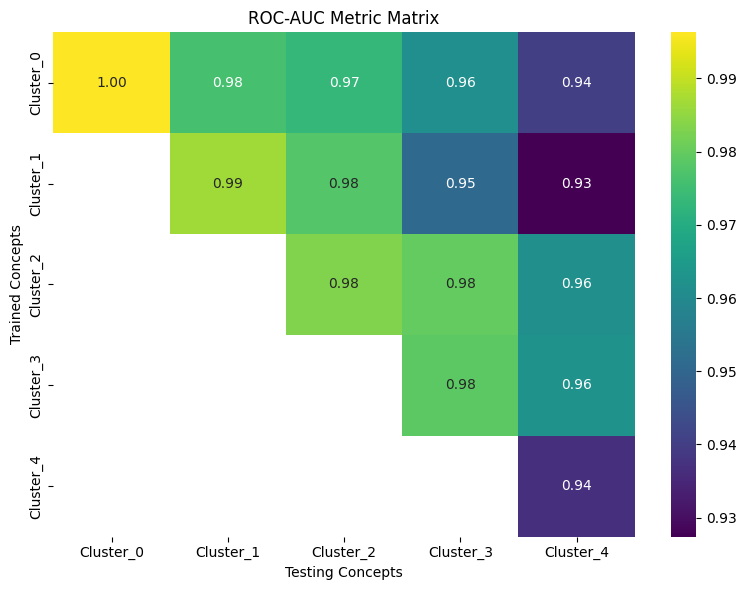

In [9]:
# test of ReservoirSamplingStrategy
from pyclad.strategies.replay.candi import CandiStrategy

strategy = CandiStrategy(
    model,
    max_buffer_size=1000,
    threshold_ratio=0.001,
)

# Run the experiment
callbacks = [
    ConceptMetricCallback(
        base_metric=RocAuc(),
        metrics=[ContinualAverage(), BackwardTransfer(), ForwardTransfer()],
    ),
    TimeEvaluationCallback(),
]
scenario = ConceptAwareScenario(dataset=dataset, strategy=strategy, callbacks=callbacks)
scenario.run()

output_writer = JsonOutputWriter(pathlib.Path("output-reservoir-unsw-cr.json"))
output_writer.write([model, dataset, strategy, *callbacks]) 

# Load results
with open("output-reservoir-unsw-cr.json", "r") as f:
    results = json.load(f)

key_metric = results["concept_metric_callback_ROC-AUC"]["metrics"]
print(key_metric)

# Locate the metric callback entry
metric_key = next(k for k in results if k.startswith("concept_metric_callback"))
metric_data = results[metric_key]

# Extract concepts order and metric matrix
concepts = metric_data["concepts_order"]
matrix = metric_data["metric_matrix"]

# Build DataFrame
df = pd.DataFrame(matrix, index=concepts, columns=concepts)

# keep only the upper triangle of the matrix, including the diagonal
df = df.where(np.triu(np.ones(df.shape), k=0).astype(bool))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("ROC-AUC Metric Matrix")
plt.ylabel("Trained Concepts")
plt.xlabel("Testing Concepts")
plt.tight_layout()
plt.show()
